# Preparation for scVI and post-scVI analysis of all donors data (nuclei and cells), only perivascular (PV) compartment

After doublets removal (both by genotype and GEX)

This the version of the manifold after running scVI by `sample` and removing genes that have been filtered according to high ambient RNA in notebook **M2**

11.11.2021

What happens here:
- preparation for scVI (calculating effect of cell cycle & figuring out optimal n_latent to use in scVI)
- load preprocessed object (raw filtered counts)
- do normalising & log transforming
- save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- calculate neighborhood graph on the latent dimensionality reporesentation from scVI
- umap
- unbiased clustering
- save

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
import bbknn
import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
annoy               NA
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bbknn               NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyte

In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202111_MFI_sc_sn_new_scVI_analysis/'

## Reading the preprocessed object

Preprocessing happened in M0 notebook

In [5]:
# reading the raw filtered object from joint analysis
adata = sc.read(save_path + 'adata_raw_filtered.h5ad')

In [6]:
# reading IDs of final cells to keep after doublet exclusion (scrublet and souporcell)
nodoublet_IDs = pd.read_csv(save_path + 'selected_droplets_no_doublets_in_M1_prelim_analysis.csv', index_col=0)
nodoublet_IDs

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


n_genes            sample  \
barcode_sample                                                   
AAACGGGCATTGGCGC-1_FCA7167219           1941        FCA7167219   
AAACGGGTCGCGATCG-1_FCA7167219           1246        FCA7167219   
AAAGATGAGCAATATG-1_FCA7167219           1516        FCA7167219   
AAAGATGAGTTCGCGC-1_FCA7167219           2099        FCA7167219   
AAAGATGCATGTCGAT-1_FCA7167219           1636        FCA7167219   
...                                      ...               ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920     2409  Pla_Camb10714920   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920     4129  Pla_Camb10714920   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920     3116  Pla_Camb10714920   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920     3696  Pla_Camb10714920   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920     2130  Pla_Camb10714920   

                                           technology  \
barcode_sample                                          
AAACGGGCATTGGCGC-1_FCA7167219        10X_3'_scRNA-seq   
AAACGGGTCGCGATCG-1_FCA7167219        10X_3'_scRNA-seq   
AAAGATGAGCAATATG-1_FCA7167219        10X_3'_scRNA-seq   
AAAGATGAGTTCGCGC-1_FCA7167219        10X_3'_scRNA-seq   
AAAGATGCATGTCGAT-1_FCA7167219        10X_3'_scRNA-seq   
...                                               ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920      10X_multiome   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920      10X_multiome   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920      10X_multiome   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920      10X_multiome   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920      10X_multiome   

                                                          tissue  dev_age  \
barcode_sample                                                              
AAACGGGCATTGGCGC-1_FCA7167219                     decidua_immune   13_PCW   
AAACGGGTCGCGATCG-1_FCA7167219                     decidua_immune   13_PCW   
AAAGATGAGCAATATG-1_FCA7167219                     decidua_immune   13_PCW   
AAAGATGAGTTCGCGC-1_FCA7167219                     decidua_immune   13_PCW   
AAAGATGCATGTCGAT-1_FCA7167219                     decidua_immune   13_PCW   
...                                                          ...      ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920  decidua_placenta_myometrium  8-9_PCW   

                                    donor               dataset  run  \
barcode_sample                                                         
AAACGGGCATTGGCGC-1_FCA7167219           6          Vento_Nature  NaN   
AAACGGGTCGCGATCG-1_FCA7167219           6          Vento_Nature  NaN   
AAAGATGAGCAATATG-1_FCA7167219           6          Vento_Nature  NaN   
AAAGATGAGTTCGCGC-1_FCA7167219           6          Vento_Nature  NaN   
AAAGATGCATGTCGAT-1_FCA7167219           6          Vento_Nature  NaN   
...                                   ...                   ...  ...   
TTTGTGTTCGTCAAGT-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTTGGTCACAGCG-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTTGGTTTACTTG-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   
TTTGTTGGTTTGAGCA-1_Pla_Camb10714920   P13  Ashley_collection_sn  NaN   

                                     number_of_individuals_multiplexed  batch  \
barcode_sample                                                                  
AAACGGGCATTGGCGC-1_FCA7167219                                        1      0   
AAACGGGTCGCGATCG-1_FCA7167219                                        1      0   
AAAGATGAGCAATATG-1_FCA7167219                                        1      0   
AAAGATGAGTTCGCGC-1_FCA7167219                                        1      0   
AAAGATGCATG

In [7]:
# subsetting the adata object to final cells
adata = adata[list(nodoublet_IDs.index), :].copy()
adata

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 378558 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19', 'feature_types-1

In [8]:
# adding metadata
for col in nodoublet_IDs.columns:
    print(col)
    adata.obs[col] = nodoublet_IDs.loc[adata.obs_names,col]

n_genes
sample
technology
tissue
dev_age
donor
dataset
run
number_of_individuals_multiplexed
batch
percent_mito
n_counts
scrublet_score
scrublet_cluster_score
bh_pval
is_doublet
celltype_predictions
probabilities
barcode_sample_copy
souporcell_assignment
inter_ind_doublet
S_score
G2M_score
phase
origin_M_F
is_doublet_0.05
is_doublet_0.01


In [9]:
np.unique(adata.obs['sample'])

array(['FCA7167219', 'FCA7167221', 'FCA7167222', 'FCA7167223',
       'FCA7167224', 'FCA7167226', 'FCA7167230', 'FCA7167231',
       'FCA7167232', 'FCA7196218', 'FCA7196219', 'FCA7196220',
       'FCA7196224', 'FCA7196225', 'FCA7196226', 'FCA7196229',
       'FCA7196231', 'FCA7474062', 'FCA7474063', 'FCA7474064',
       'FCA7474065', 'FCA7474066', 'FCA7474068', 'FCA7474069',
       'FCA7511881', 'FCA7511882', 'FCA7511883', 'FCA7511884',
       'FCA7511885', 'FCA7511886', 'Pla_Camb10691970', 'Pla_Camb10691971',
       'Pla_Camb10691972', 'Pla_Camb10691975', 'Pla_Camb10714918',
       'Pla_Camb10714919', 'Pla_Camb10714920', 'Pla_HDBR10142767',
       'Pla_HDBR10142768', 'Pla_HDBR10142769', 'Pla_HDBR10142770',
       'Pla_HDBR10142863', 'Pla_HDBR10142864', 'Pla_HDBR10142865',
       'Pla_HDBR10701666', 'Pla_HDBR10701667', 'Pla_HDBR10701668',
       'Pla_HDBR10917730', 'Pla_HDBR10917731', 'Pla_HDBR10917733',
       'Pla_HDBR8624430', 'Pla_HDBR8624431', 'Pla_HDBR8715512',
       'Pla_HDBR87

In [10]:
# quick check to see if raw is raw or not
expr_mtx_dense = adata[adata.obs['sample'] == 'Pla_Camb10691970'].X.todense()

In [11]:
# YAS we all good
np.unique(expr_mtx_dense)

matrix([[   0.,    0.,    0., ..., 4162., 4637., 6366.]], dtype=float32)

In [12]:
# subsetting to only trophoblast according to coarse annotation done in notebook M4
annot_coarse = pd.read_csv(save_path + 'obs_table_with_coarse_annot_from_M4_notebook_all_cell_states.csv',
                          index_col=0)
adata.obs['annot_coarse'] = annot_coarse.loc[adata.obs_names,'annot_coarse']
adata.obs['annot_coarse'].value_counts()

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


dS_uSMC        158106
Trophoblast     81704
Myeloid         43997
NK              30132
T               19244
Epithelial      18222
Endothelial     12689
fF              12633
PV               1831
Name: annot_coarse, dtype: int64

In [13]:
adata

AnnData object with n_obs × n_vars = 378558 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_

In [14]:
adata = adata[adata.obs['annot_coarse'] == 'PV'].copy()
adata

AnnData object with n_obs × n_vars = 1831 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

________

# Preparation for scVI: 

1) Calculating cell cycle-associated genes (to later be excluded in scVI analysis)
2) Calculating a minimum extimate of number of latent variables to use in scVI analysis later (when doing batch correction) as the number of PCs optimally explaining this data

Let's see if cell cycle has an effect in trophoblast and remember them to exclude in scVI calculation

In [15]:
adata_copy = adata.copy()

In [16]:
# normalise and log transform
sc.pp.normalize_per_cell(adata_copy, counts_per_cell_after=1e4)
sc.pp.log1p(adata_copy)

# saving normalised and log transformed values into the raw attribute to later be able to plot
adata_copy.raw = adata_copy.copy()

adata_copy.var_names_make_unique()
adata_copy.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [17]:
# excluding soupy genes as per notebook M2

# gene stats for cells
gene_stats_sc = pd.read_csv(save_path + 'gene_filter_cells_upd_20211111.csv', index_col=0)

# gene stats for nuclei
gene_stats_sn = pd.read_csv(save_path + 'gene_filter_nuclei_upd_20211111.csv', index_col=0)

genes2keep_sc = list(gene_stats_sc[gene_stats_sc['Selected'] == True].index)
genes2keep_sn = list(gene_stats_sn[gene_stats_sn['Selected'] == True].index)

# overlap
genes2keep = list(set(genes2keep_sc) & set(genes2keep_sn))

len(genes2keep)

7849

In [18]:
#adata_copy = adata_copy[:,list(set(genes2keep) & set(adata_copy.var_names))].copy()
adata_copy

AnnData object with n_obs × n_vars = 1831 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

_____________________________________________________________________________________________________________________________________________________________

### Filter Cell cycle genes 
Per genes analysis: identify genes behaving like known cell cycle genes

extracting highly variable genes
    finished (0:00:00)


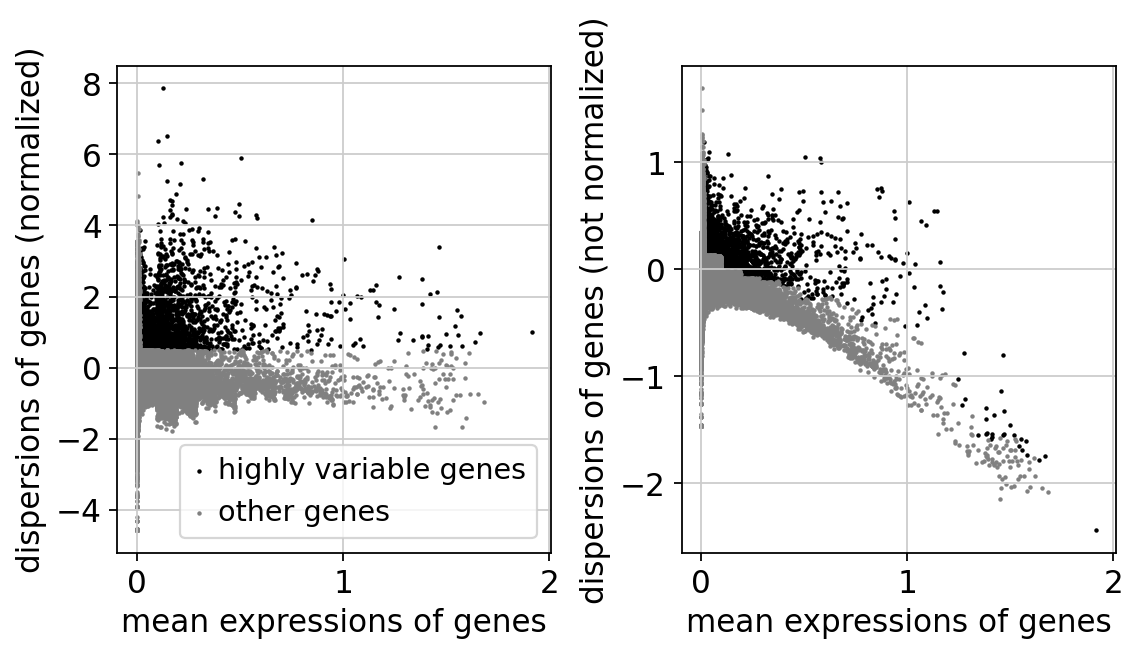

In [19]:
cellcycle_adata = adata_copy.copy()
# Extract highly variable genes
filter_result = sc.pp.filter_genes_dispersion(
    cellcycle_adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result,save='_ccg_identification.pdf')

In [20]:
# Traspose matrix for a GENE-centered analysis
cellcycle_adata = cellcycle_adata.T
cellcycle_adata = cellcycle_adata[filter_result.gene_subset,:]


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
# Scale data to unit variance and zero mean
sc.pp.scale(cellcycle_adata, max_value=10)
# PCA
sc.tl.pca(cellcycle_adata, svd_solver='arpack')

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:00)


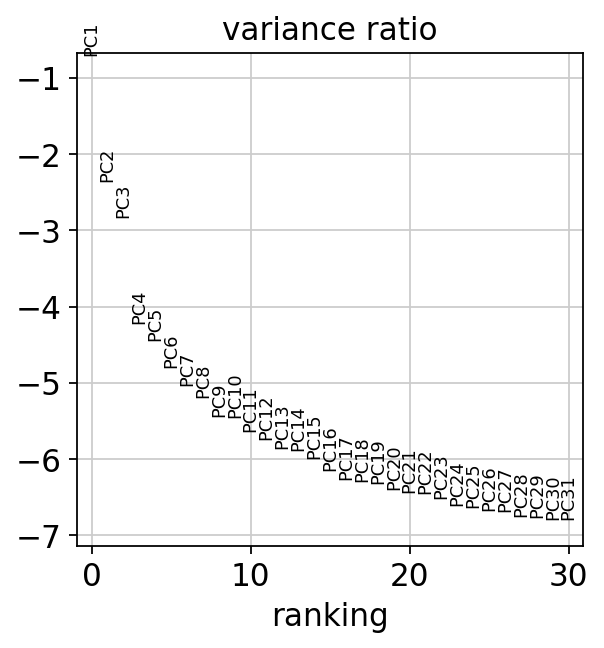

In [22]:
# Plot the variance ratio
sc.pl.pca_variance_ratio(cellcycle_adata, log=True, save='_ccg_identification.pdf')

computing neighbors
    using 'X_pca' with n_pcs = 9
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'tissue' as categorical
... storing 'dev_age' as categorical
... storing 'donor' as categorical
... storing 'dataset' as categorical
... storing 'celltype_predictions' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'phase' as categorical
... storing 'origin_M_F' as categorical
... storing 'annot_coarse' as categorical


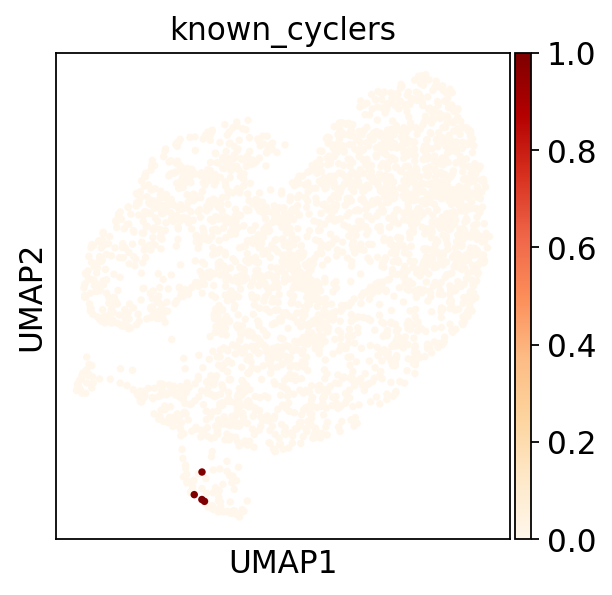

In [23]:
# Identify genes behaving like cc genes
num_pcs = 9
# Compute a neighborhood graph of observations
sc.pp.neighbors(cellcycle_adata,n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(cellcycle_adata)
cellcycle_adata.obs['known_cyclers'] = [1 if gene in ['CDK1','MKI67','CCNB2','PCNA'] else 0 for gene in cellcycle_adata.obs_names]
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers'],color_map='OrRd',save='_ccg_identification.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


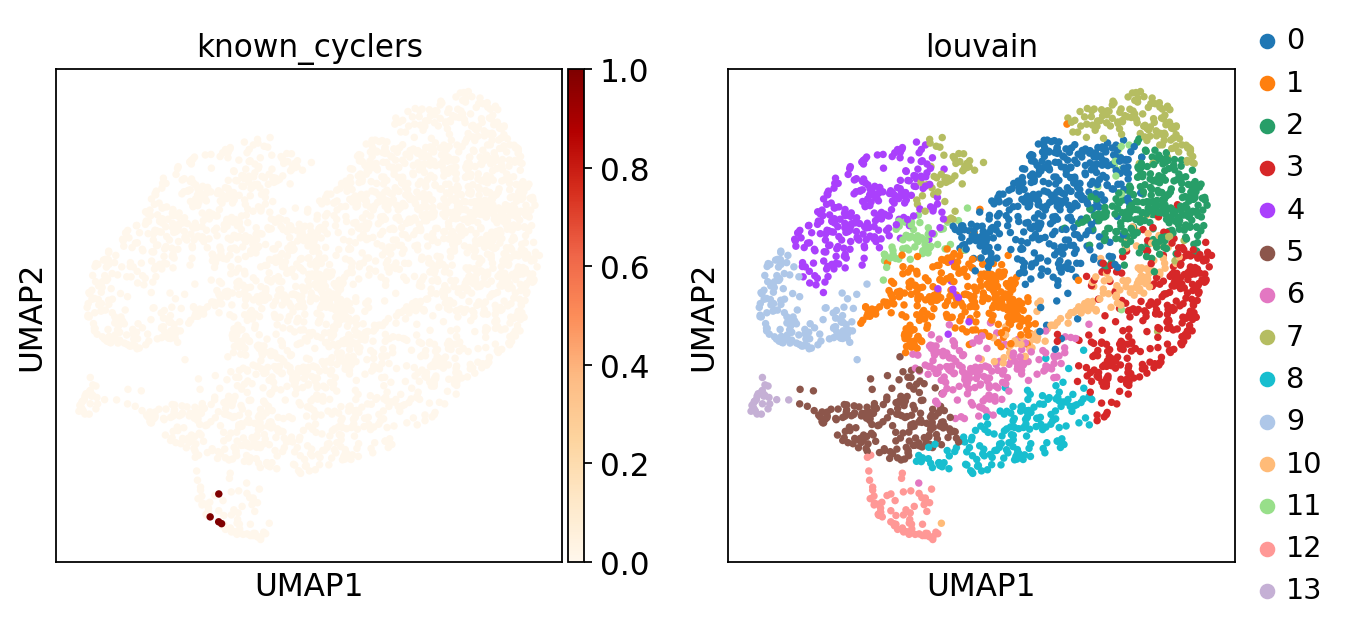

In [24]:
# Cluster GENES into subgroups using louvain
sc.tl.louvain(cellcycle_adata, resolution=1.0)
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers',
                                  'louvain'],color_map='OrRd',save='_ccg_identification.pdf')

In [25]:
for gene in ['CDK1','MKI67','CCNB2','PCNA']:
    print(gene, 'in current features:', gene in cellcycle_adata.obs_names)

CDK1 in current features: True
MKI67 in current features: True
CCNB2 in current features: True
PCNA in current features: True


In [27]:
# Locate genes of interests' cluster
print(cellcycle_adata.obs.loc[['CDK1',
                                'MKI67',
                               'CCNB2','PCNA',
                              ],'louvain'])


CDK1     12
MKI67    12
CCNB2    12
PCNA     12
Name: louvain, dtype: category
Categories (14, object): ['0', '1', '2', '3', ..., '10', '11', '12', '13']


In [28]:
cellcycle_adata.obs['louvain'].value_counts()

0     416
1     297
2     280
3     274
4     264
5     189
6     182
7     175
8     165
9     137
10    128
11     70
12     65
13     28
Name: louvain, dtype: int64

In [29]:
adata_copy

AnnData object with n_obs × n_vars = 1831 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

So removing cluster 12 genes here

In [30]:
# Add unstructured dict-like annotation for ccgs
adata_copy.uns['ccgs'] = list(cellcycle_adata.obs[(cellcycle_adata.obs['louvain']=='12')].index)
# Remove cc genes
adata_copy = adata_copy[:,[i not in adata_copy.uns['ccgs'] for i in adata_copy.var_names]]


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [31]:
adata_copy

View of AnnData object with n_obs × n_vars = 1831 × 30735
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 

In [32]:
# save this table to use in scVI analysis
adata_copy.var.to_csv(save_path + 'cleaned_up_genes_in_S9_notebook_PV_20211114.csv')

# Subsetting to HVGs & scaling

In [33]:
%%time
sc.pp.highly_variable_genes(adata_copy, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


CPU times: user 842 ms, sys: 667 µs, total: 843 ms
Wall time: 841 ms


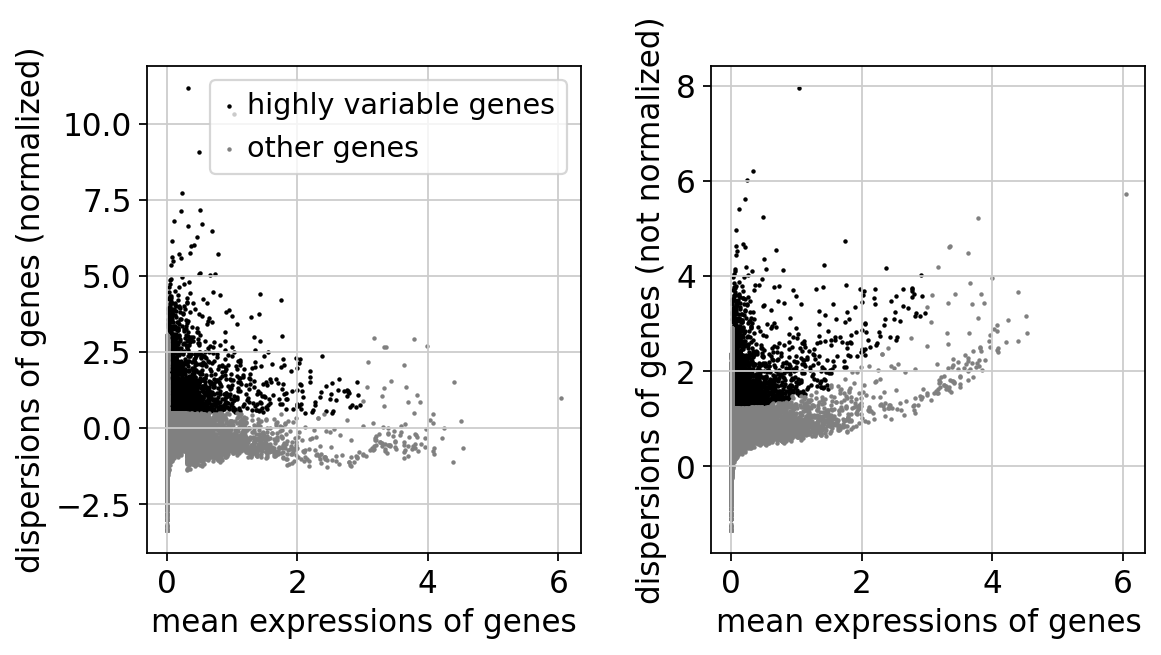

CPU times: user 1.13 s, sys: 18 ms, total: 1.15 s
Wall time: 1.15 s


In [34]:
%%time
sc.pl.highly_variable_genes(adata_copy)

In [35]:
adata_copy_hvg = adata_copy[:, adata_copy.var['highly_variable']]

In [36]:
adata_copy_hvg

View of AnnData object with n_obs × n_vars = 1831 × 4228
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', '

In [37]:
%%time
sc.pp.scale(adata_copy_hvg, max_value=10)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


CPU times: user 219 ms, sys: 4.92 ms, total: 224 ms
Wall time: 221 ms


________

### PCA

In [38]:
%%time
sc.tl.pca(adata_copy_hvg, svd_solver='arpack', n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


CPU times: user 1.93 s, sys: 1.32 s, total: 3.26 s
Wall time: 464 ms


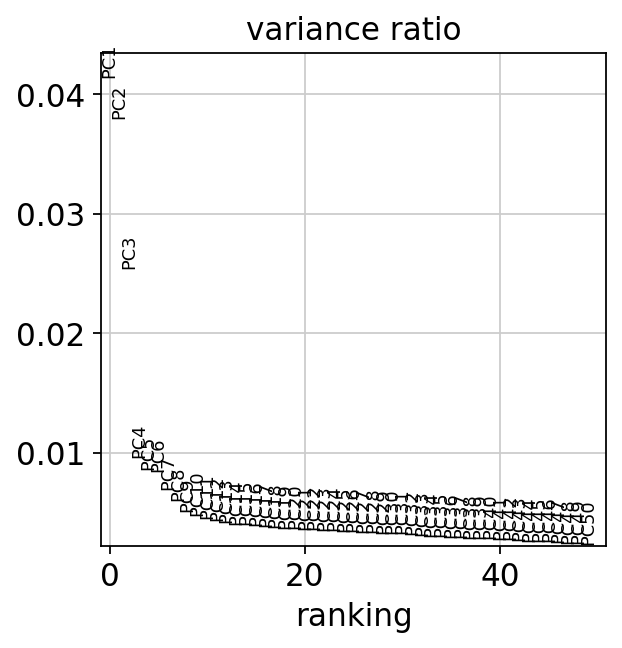

In [39]:
sc.pl.pca_variance_ratio(adata_copy_hvg, n_pcs=50)

In [40]:
# decision: using n_latent = 9 in scVI

From here following to run scVI in: `/nfs/team292/aa22/scVI_related/202111_upd_in_vivo_analysis/all_donors_analysis/scVI_integration.ipynb`

________

Carrying on to 
- Normalise and log transform
- Save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- Make cell names (obs) and gene names (var) unique

In [41]:
# normalise and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# saving normalised and log transformed values into the raw attribute to later be able to plot
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing by total count per cell
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


_____________________________________________________________________________________________________________________________________________________________

In [42]:
# Assign cell cycle stage & scores
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/notebooks/Vento_Lab/regev_lab_cell_cycle_genes_from_Luz_20200505.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    503 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    377 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [43]:
adata

AnnData object with n_obs × n_vars = 1831 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

_______________________________________________________________________________________________________

# Read in scVI-calculated latent representation

In [44]:
n_latent = [9]
n_layers = [3]

### 14.11.2021 run, correction by `sample`

In [46]:
latent_representations = {}

for n_layers_value in n_layers:
    print(n_layers_value)
    
    curr_path = '/nfs/team292/aa22/scVI_related/202111_upd_in_vivo_analysis/all_donors_analysis/results/20211114_obsm_with_scVI_latent_representation_n_9_after_all_doublet_exclusion_by_sample_PV_compartment_with_LF_gene_filter_n_layers_' + str(n_layers_value) + '.csv' 
         
    latent_representations[n_layers_value] = pd.read_csv(curr_path, index_col=0)

3


In [48]:
# assign these latent_representations into adata.obsm
for n_layers_value in n_layers:
    print(n_layers_value)
    adata.obsm['X_scVI_n_latent_9_sample_n_layers_' + str(n_layers_value)] = np.array(latent_representations[n_layers_value])

3


In [49]:
adata.obsm['X_scVI_n_latent_9_sample_n_layers_3'].shape

(1831, 9)

__________________________________________________________________________________________________________________________________________________________________

### Neighbourhood graph & UMAP

In [50]:
%%time

for n_layers_value in n_layers:
    print(n_layers_value)
    sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_scVI_n_latent_9_sample_n_layers_' + str(n_layers_value),
               key_added='neighbors_scVI_n_latent_9_sample_n_layers_' + str(n_layers_value))

computing neighbors
    finished: added to `.uns['neighbors_scVI_n_latent_9_sample_n_layers_3']`
    `.obsp['neighbors_scVI_n_latent_9_sample_n_layers_3_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_scVI_n_latent_9_sample_n_layers_3_connectivities']`, weighted adjacency matrix (0:00:00)


3
CPU times: user 682 ms, sys: 832 ms, total: 1.51 s
Wall time: 150 ms


In [51]:
adata

AnnData object with n_obs × n_vars = 1831 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

__________________________________________________________________________________________________________________________________________________________________

In [52]:
%%time
# takes a few minutes
for n_layers_value in n_layers:
    print(n_layers_value)
    
    sc.tl.umap(adata, random_state=0,
              neighbors_key='neighbors_scVI_n_latent_9_sample_n_layers_' + str(n_layers_value))
    # copy current adata.obsm['X_umap'] into adata.obsm['X_umap_scVI_n_latent_' + str(n_latent_value)]
    adata.obsm['X_umap_scVI_n_latent_9_sample_n_layers_' + str(n_layers_value)] = adata.obsm['X_umap']
    
    

computing UMAP


3


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


CPU times: user 3.67 s, sys: 1.09 s, total: 4.76 s
Wall time: 2.91 s


In [53]:
np.unique(adata.obs['sample'], return_counts=True)

(array(['FCA7167223', 'FCA7167224', 'FCA7167226', 'FCA7196220',
        'FCA7196224', 'FCA7196225', 'FCA7196226', 'FCA7474065',
        'FCA7474066', 'FCA7474068', 'FCA7511881', 'FCA7511884',
        'FCA7511885', 'FCA7511886', 'Pla_Camb10691970', 'Pla_Camb10691972',
        'Pla_HDBR10142767', 'Pla_HDBR10142768', 'Pla_HDBR10142769',
        'Pla_HDBR10142770', 'Pla_HDBR10142863', 'Pla_HDBR10142864',
        'Pla_HDBR10701666', 'Pla_HDBR10701667', 'Pla_HDBR10701668',
        'Pla_HDBR10917730', 'Pla_HDBR10917731', 'Pla_HDBR10917733',
        'Pla_HDBR8624431', 'WSSS_PLA8764121', 'WSSS_PLA8764122',
        'WSSS_PLA8810750', 'WSSS_PLA8810751', 'WSSS_PLA8811069',
        'WSSS_PLA8811070'], dtype=object),
 array([ 21, 275,   1, 655,   1, 503, 262,   3,   2,   2,   1,   1,   3,
          2,   1,   2,   2,   1,   1,   1,   2,   2,  10,   8,   4,  27,
          9,   1,   6,   5,   8,   3,   2,   2,   2]))

In [54]:
adata

AnnData object with n_obs × n_vars = 1831 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

## Saving this object with all the manifolds calculated

In [55]:
adata.write(save_path + 'adata_scVI_analysed_corr_by_sample_PV_with_LF_gene_filter.h5ad')



... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'tissue' as categorical
... storing 'dev_age' as categorical
... storing 'donor' as categorical
... storing 'dataset' as categorical
... storing 'celltype_predictions' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'phase' as categorical
... storing 'origin_M_F' as categorical
... storing 'annot_coarse' as categorical


In [5]:
# reading the previously saved file
adata = sc.read(save_path + 'adata_scVI_analysed_corr_by_sample_PV_with_LF_gene_filter.h5ad')


In [56]:
# to better distinguish predictions from Vento-Tormo dataset
colors_VT = ['#C1B4A7','#E8D6E0','#40ab5d','#F4BF73','#F7B5A4',
                 '#d8e7a4','#2ECCFA','#39728C','#FA5858','#E9A1C7',
                 '#B40486','#004529','#C49A6C','#9255a0', '#58595B', '#A3A8AD',
                 '#F6D8CE','#633A6D','#C7E0BD','#49ABC8', '#E7C949', '#F7F297', '#af9e56',
                 '#ED1B64','#E59C24','#C2E8F6','#677EB2','#73FDD6', '#BC3122', '#771A15',
                 '#E6C6F7','#CEE3F6','#CECEF6','#677EB2','#6363A5','#63A585',
                 '#246D66','#9B8579']

### scVI-corrected by `sample`

n_latent = 9, n_layers = 3

In [6]:
curr_embedding_key = 'X_umap_scVI_n_latent_9_sample_n_layers_3'

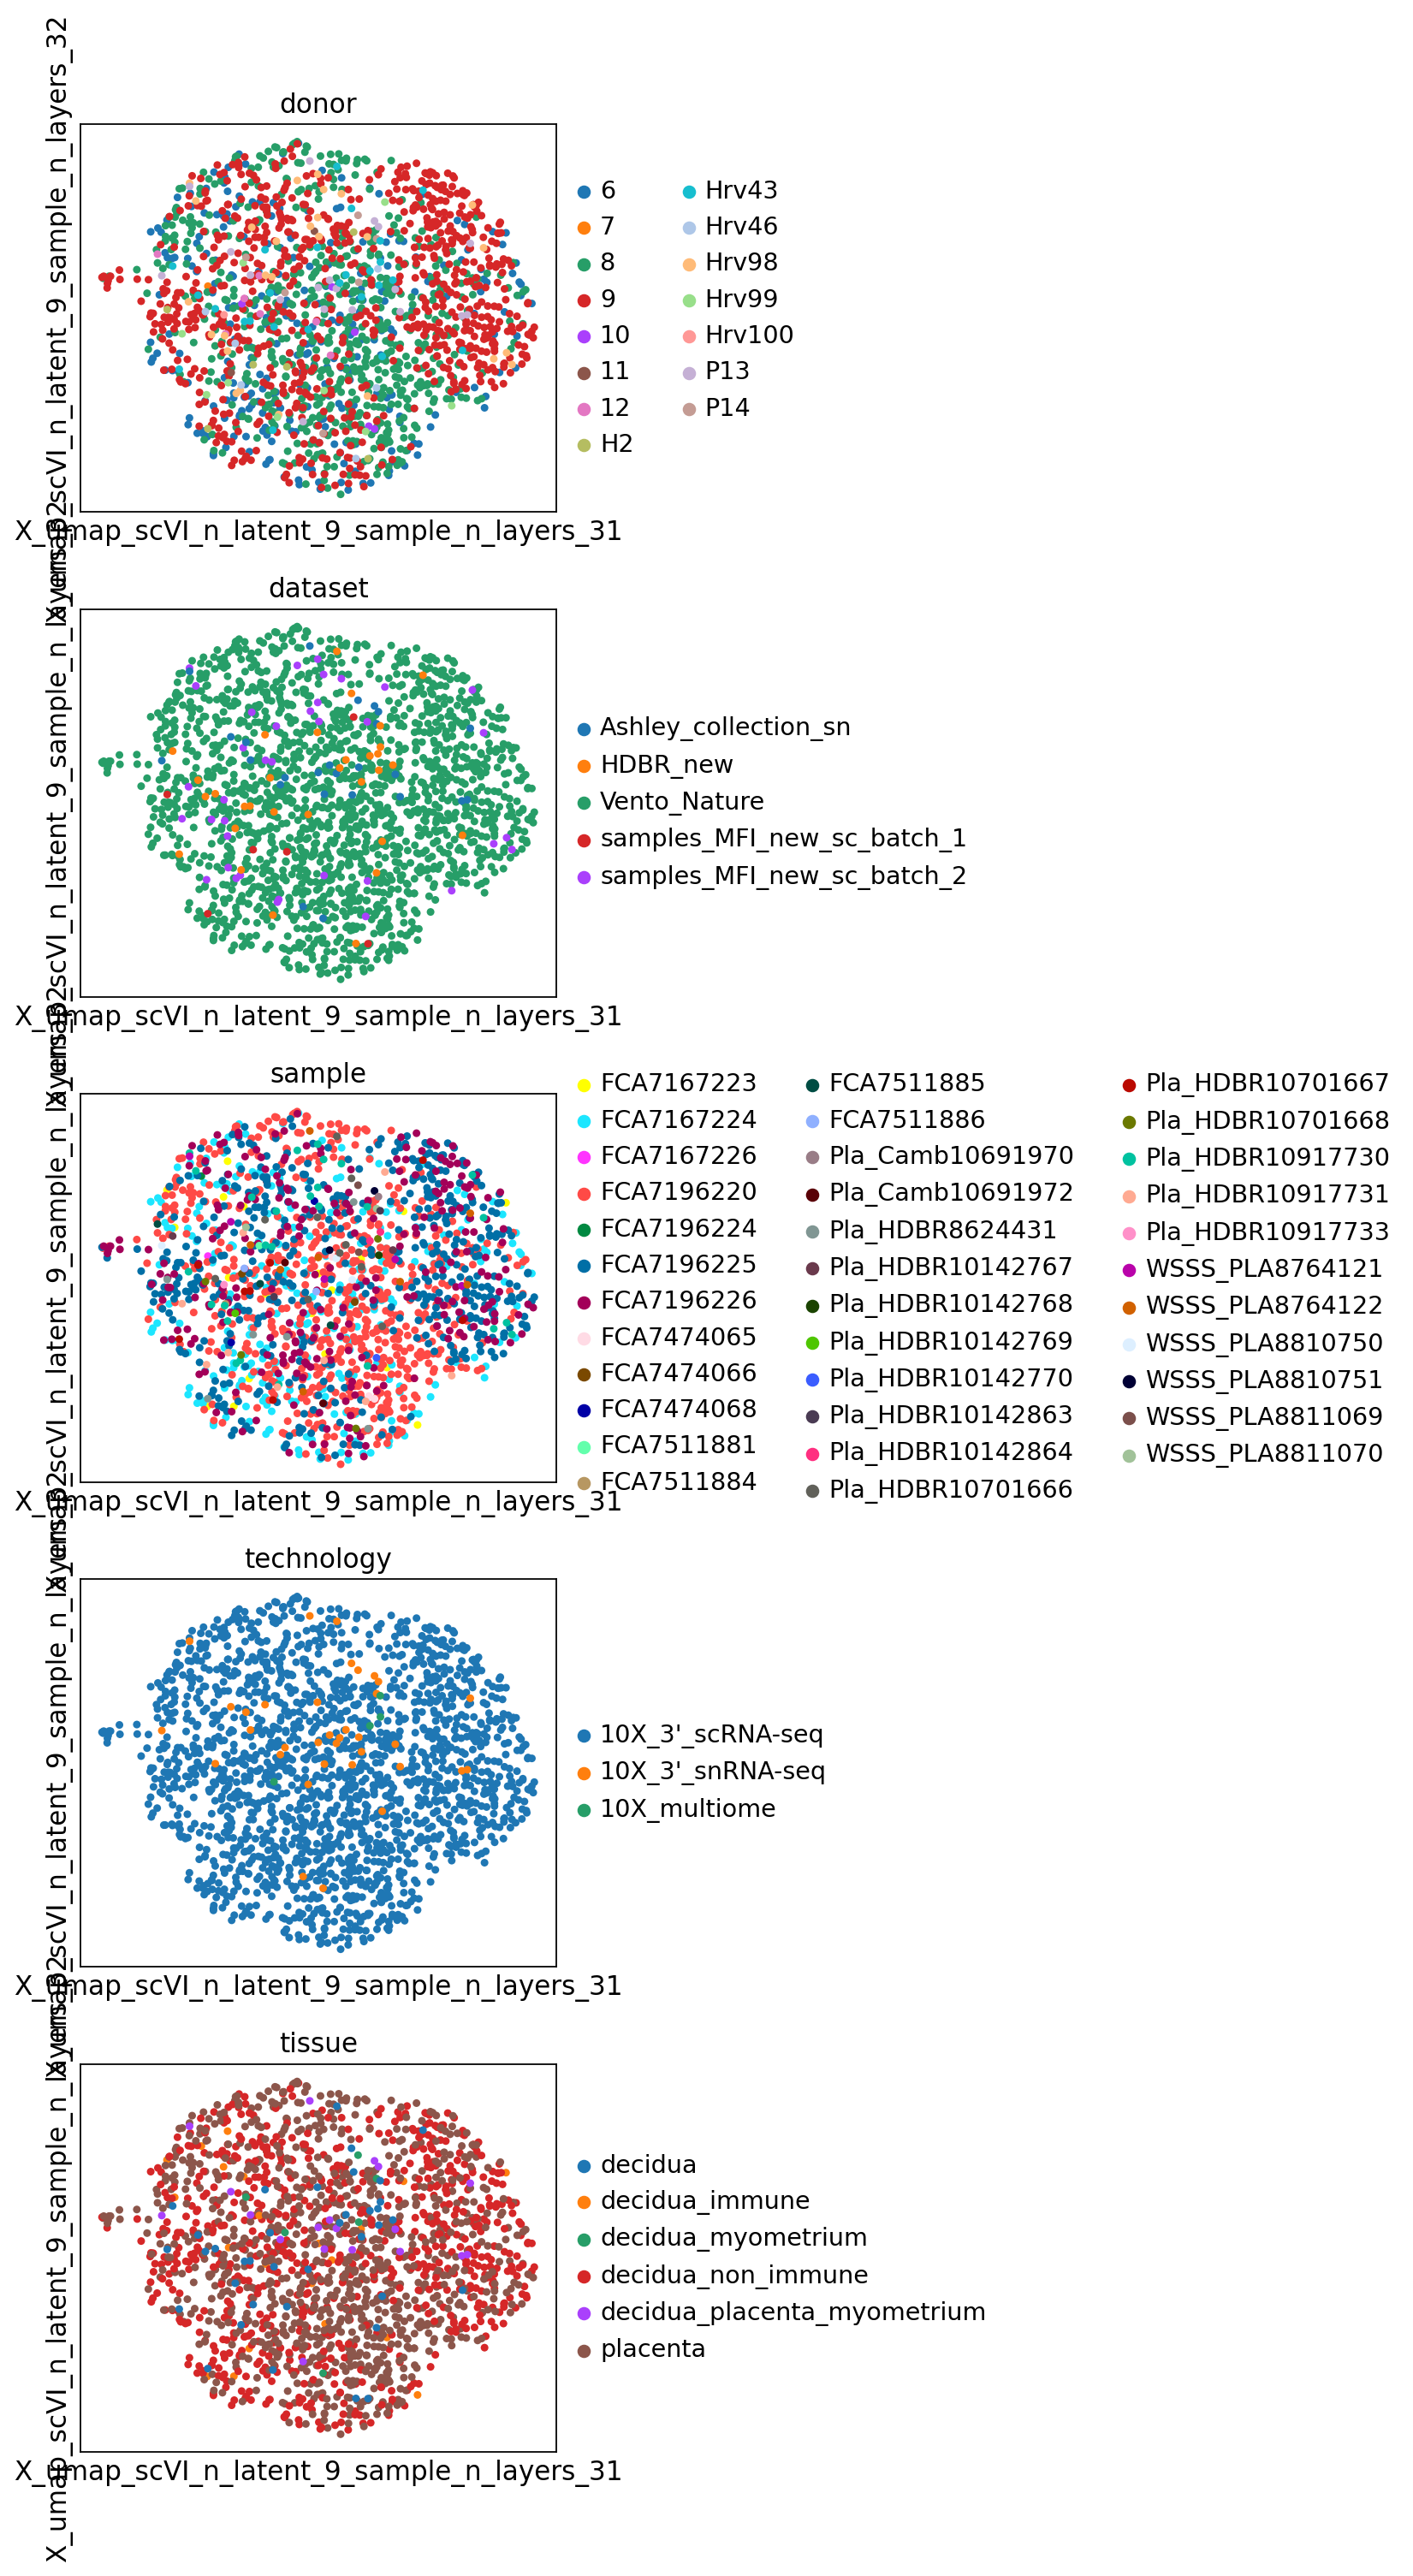

In [58]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['donor','dataset','sample','technology','tissue'], ncols=1)

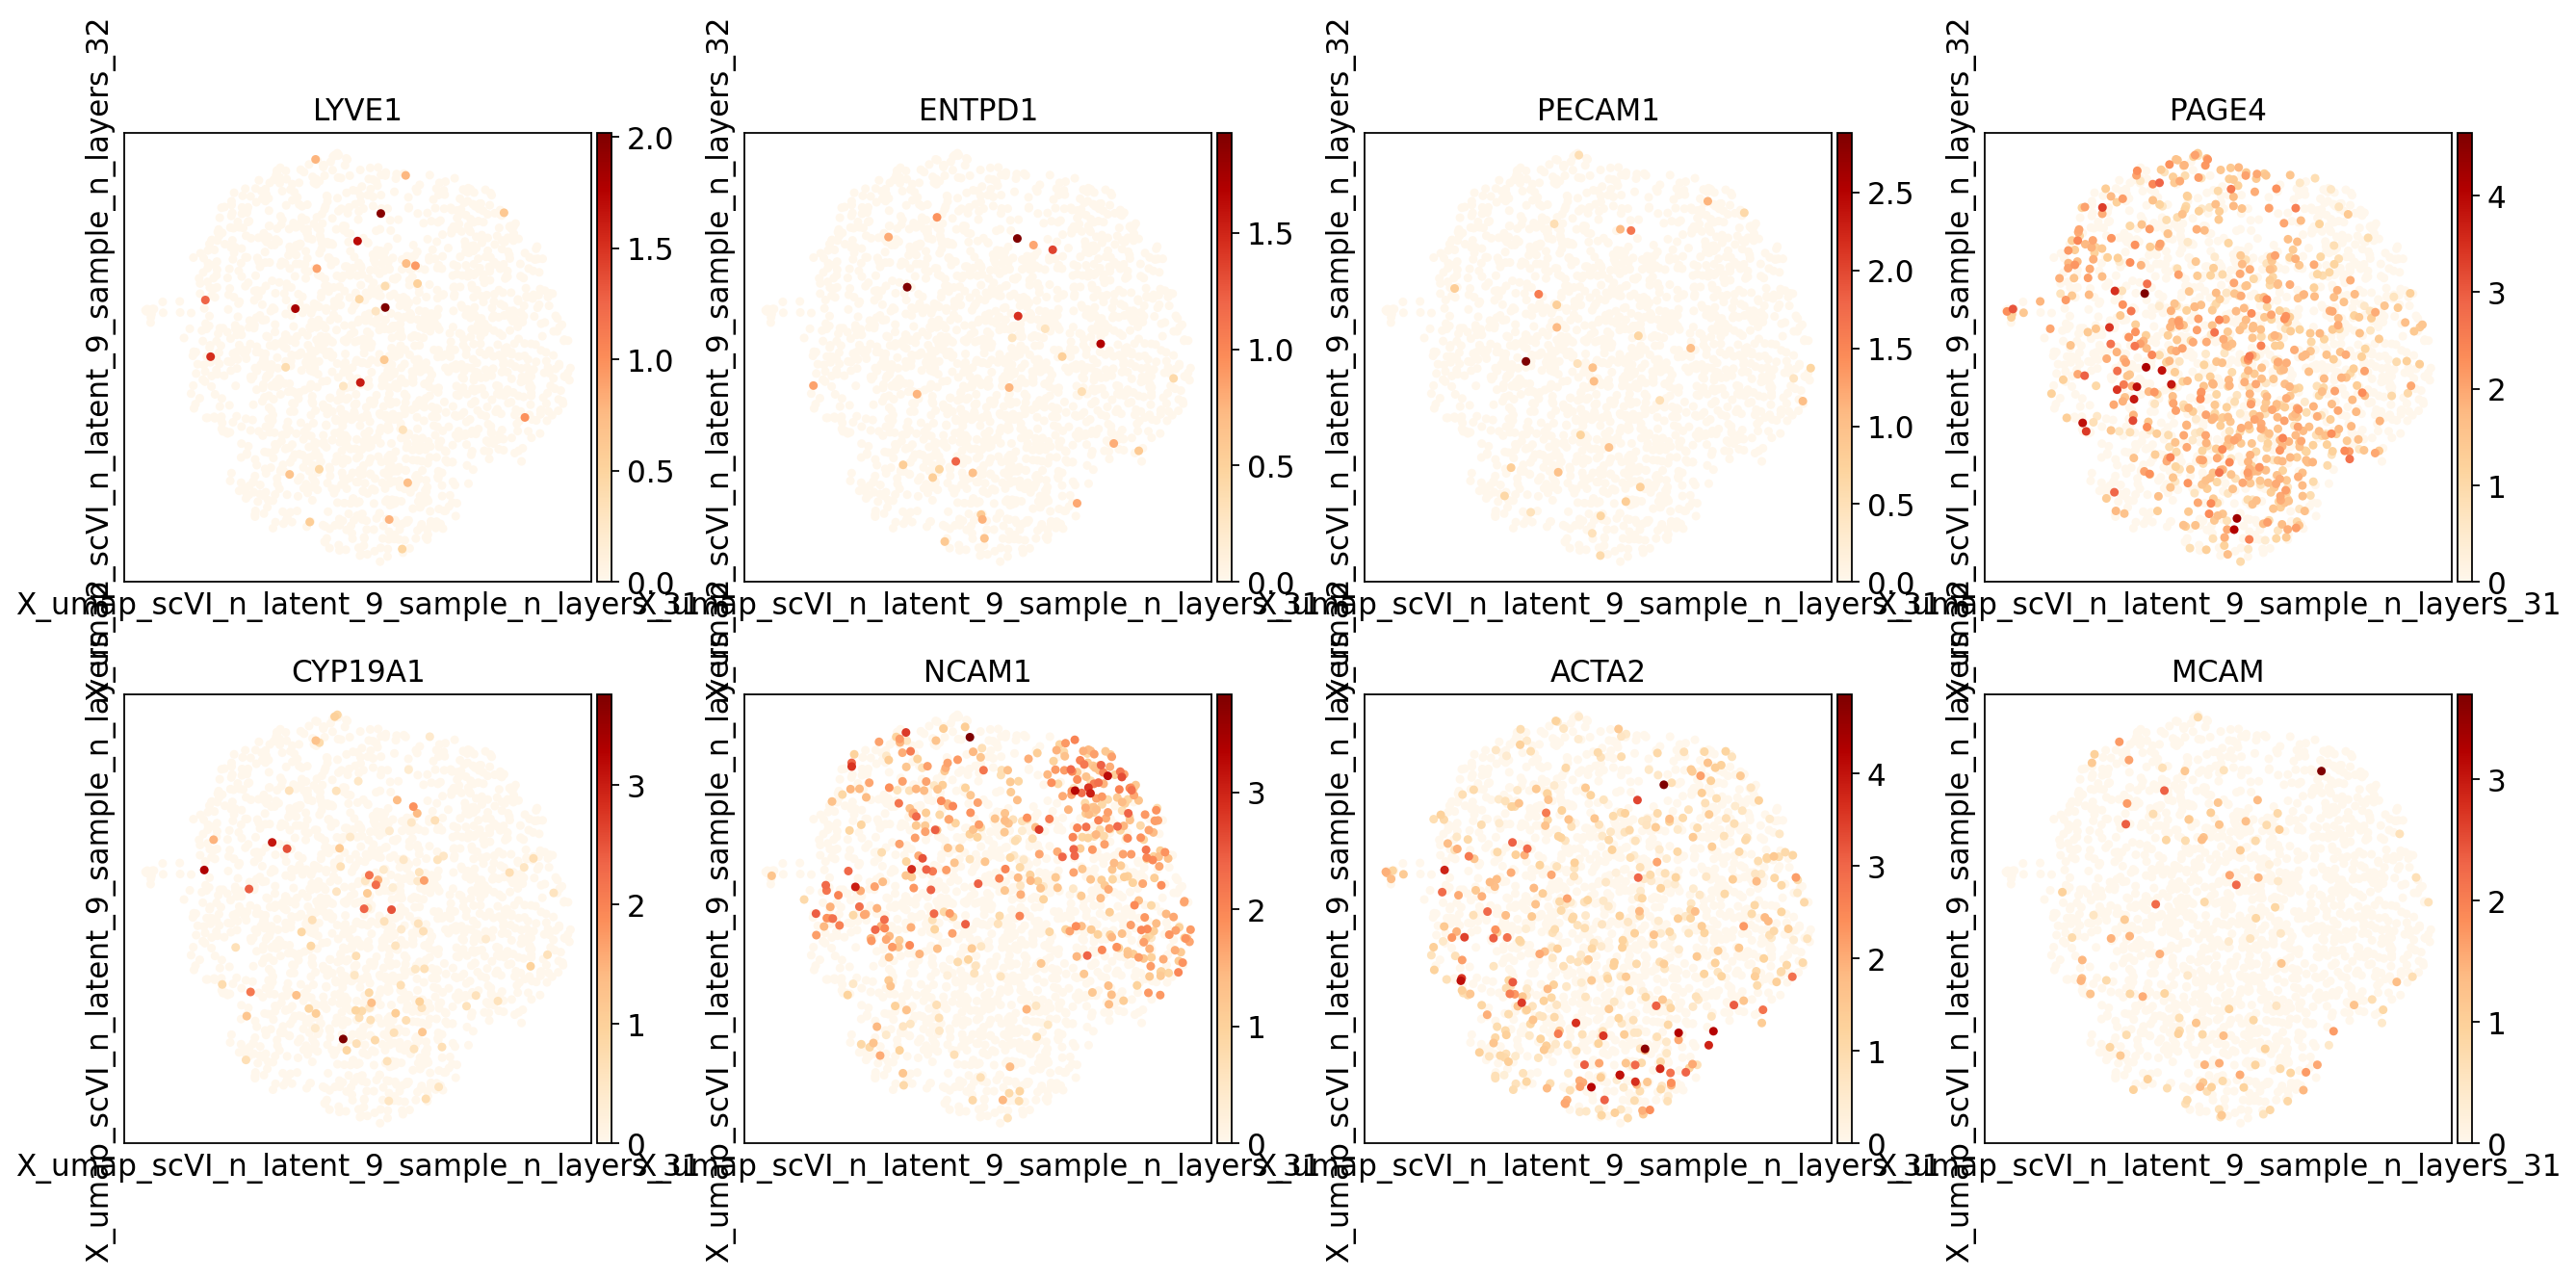

In [11]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['LYVE1', # Endo_f and Endo_L
                       'ENTPD1', # Endo_M
                       'PECAM1', # high in M and F
                       'PAGE4', # Endo_F
                       'CYP19A1', # SCT
                       'NCAM1', # NK
                       'ACTA2', # dS?
                       
                       # a bit more in dPV1
                       'MCAM'], cmap='OrRd', #ncols=2,
               
               )

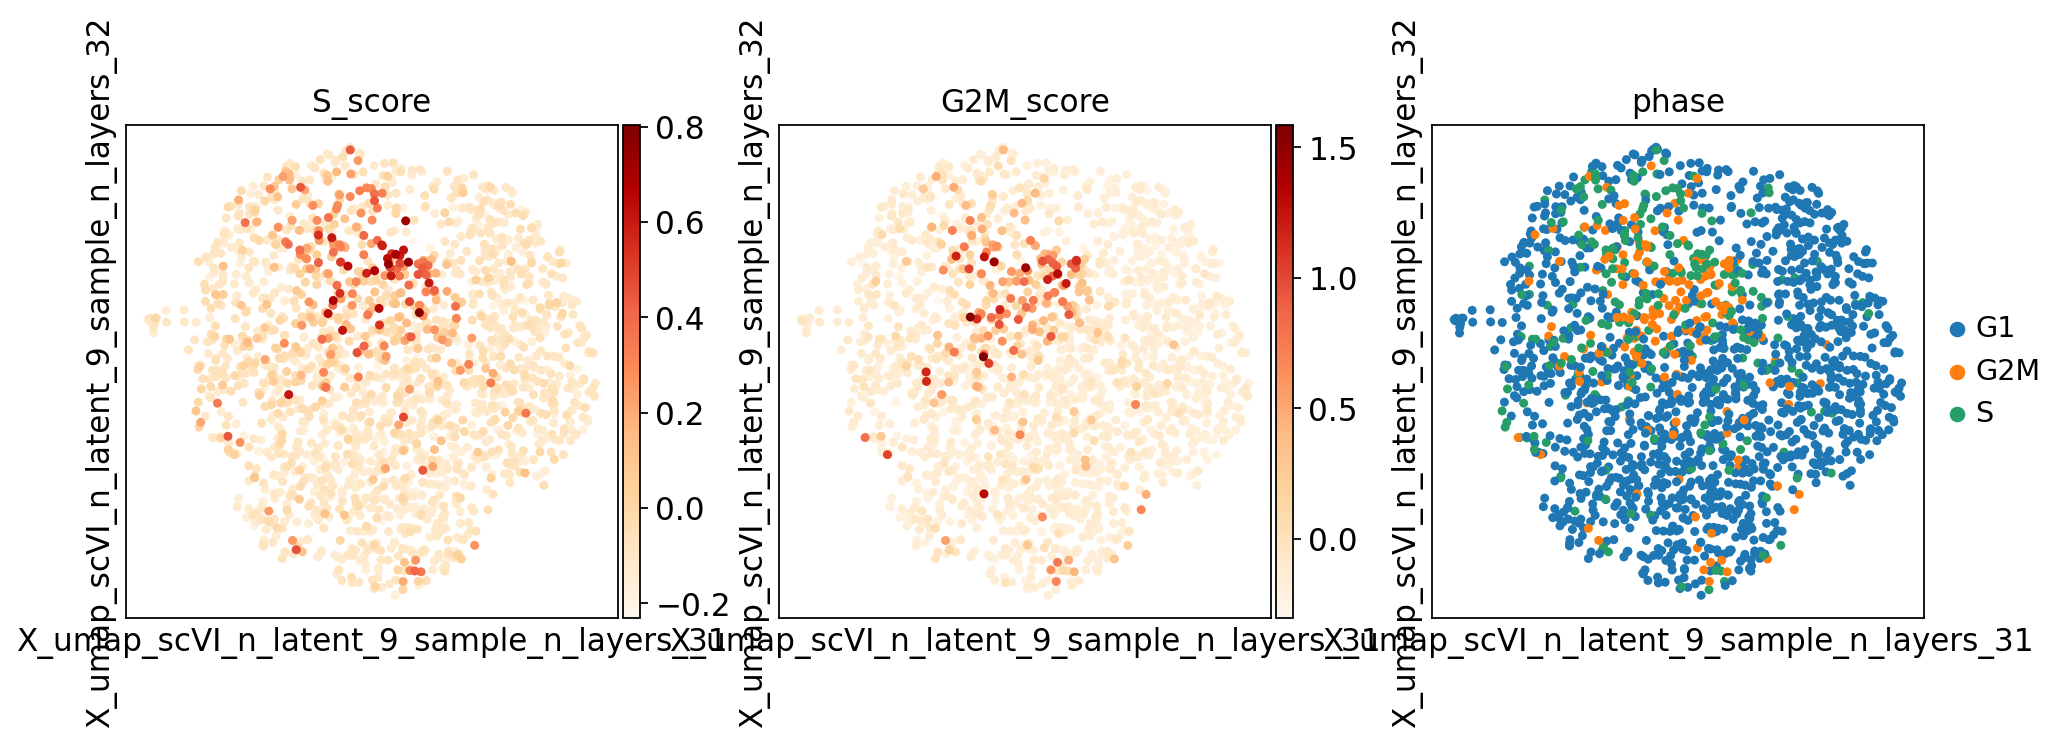

In [60]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['S_score','G2M_score','phase'], cmap='OrRd')

In [61]:
adata

AnnData object with n_obs × n_vars = 1831 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

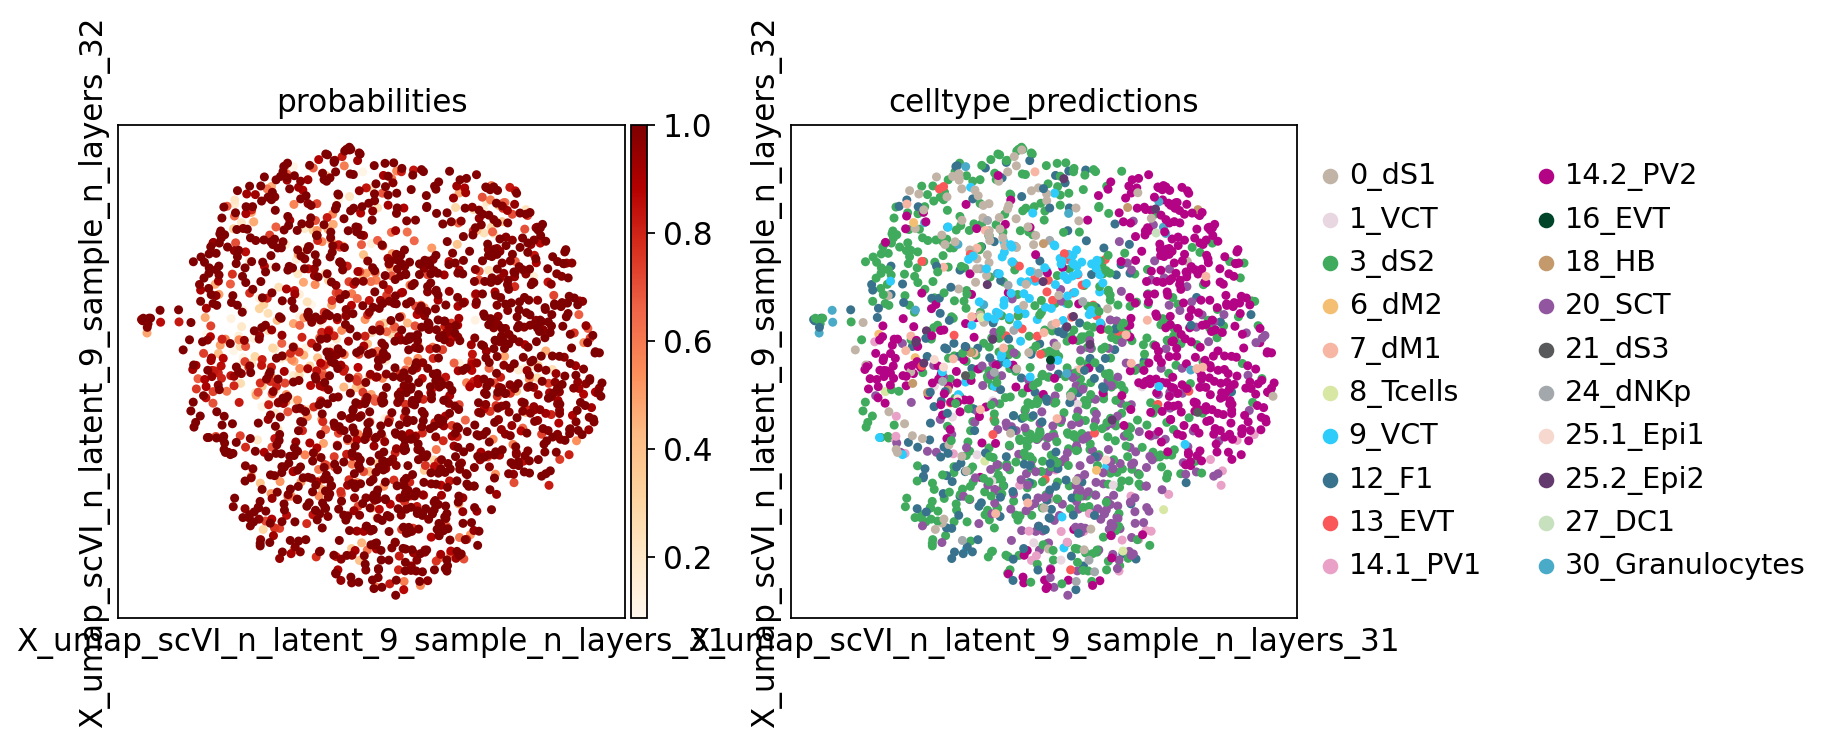

In [62]:
sc.pl.embedding(adata, curr_embedding_key,
                color=['probabilities','celltype_predictions'], cmap='OrRd', ncols=2,
               palette=colors_VT)

In [63]:
adata

AnnData object with n_obs × n_vars = 1831 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'celltype_predictions', 'probabilities', 'barcode_sample_copy', 'souporcell_assignment', 'inter_ind_doublet', 'S_score', 'G2M_score', 'phase', 'origin_M_F', 'is_doublet_0.05', 'is_doublet_0.01', 'annot_coarse'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_id

### Let's cluster the data in the version of the object with n_layers = 3 and label contaminants / doublet clusters


In [64]:
sc.tl.louvain(adata, resolution=0.5,
             neighbors_key = 'neighbors_scVI_n_latent_9_sample_n_layers_3',
             key_added = 'louvain_scVI_n_latent_9_sample_n_layers_3')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain_scVI_n_latent_9_sample_n_layers_3', the cluster labels (adata.obs, categorical) (0:00:00)


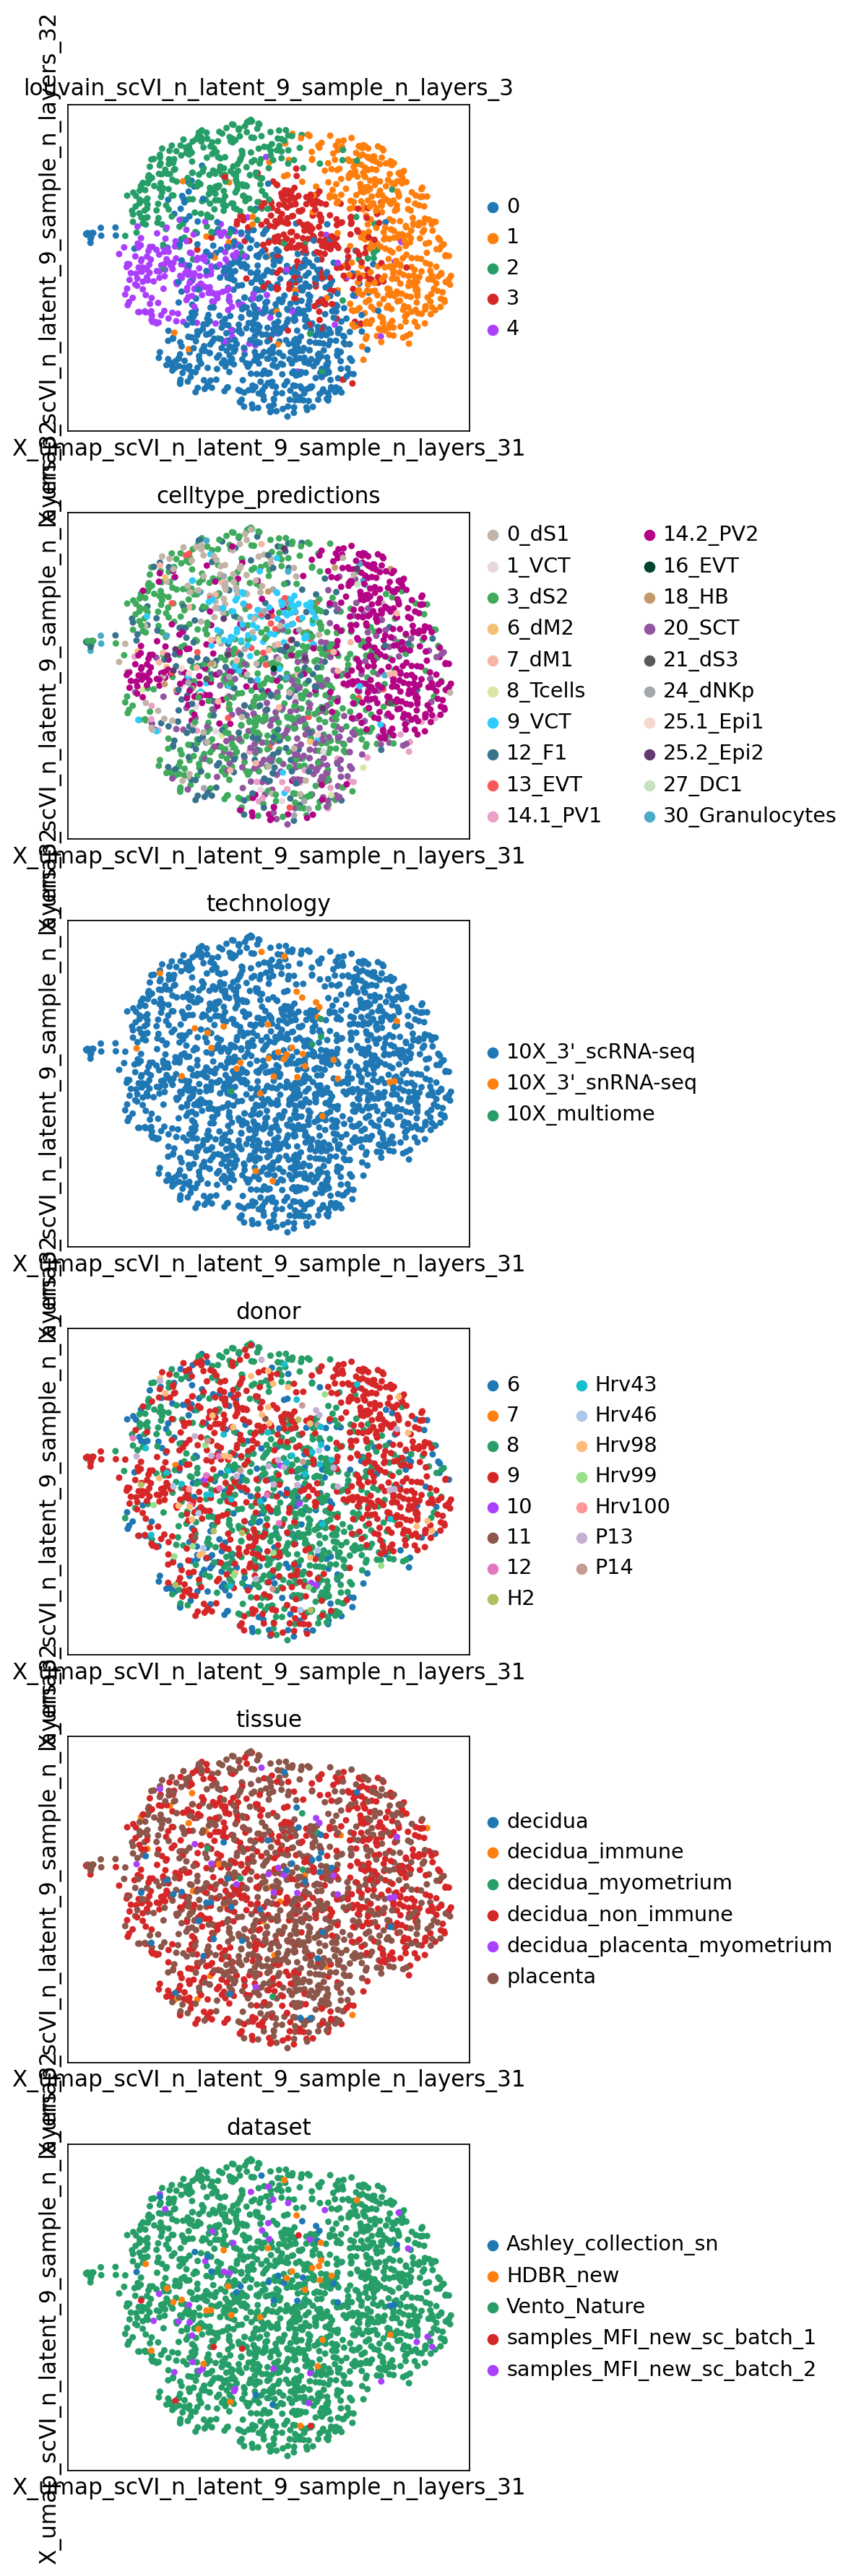

In [65]:
sc.pl.embedding(adata, curr_embedding_key, color=['louvain_scVI_n_latent_9_sample_n_layers_3',
                                                 'celltype_predictions','technology','donor', 'tissue','dataset'],
               ncols=1
               )

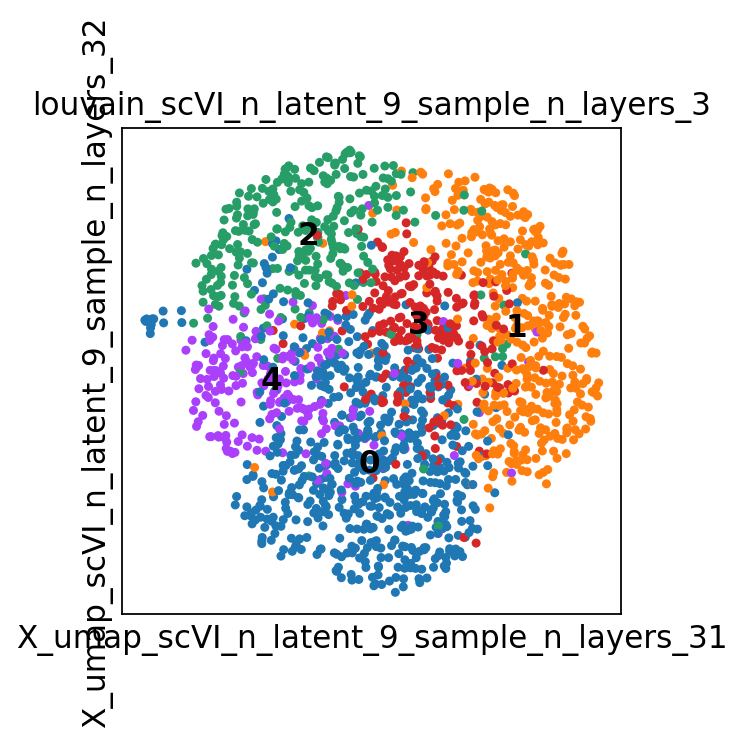

In [66]:
sc.pl.embedding(adata, curr_embedding_key, color=['louvain_scVI_n_latent_9_sample_n_layers_3',
                                                 #'celltype_predictions','annotations_P13_troph','donor','technology'
                                                 ], legend_loc='on data',
               ncols=1
               )

# DE

In [67]:
adata_raw = sc.read(save_path + 'adata_raw_filtered.h5ad')

In [68]:
adata_raw.X.shape

(430136, 30800)

In [69]:
adata_raw = adata_raw[adata.obs_names,:].copy()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [71]:
adata_raw.obs['louvain'] = adata.obs['louvain_scVI_n_latent_9_sample_n_layers_3']

In [72]:
%%time
# quick DE
sc.tl.rank_genes_groups(adata_raw, groupby='louvain', n_genes=1000, method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


CPU times: user 2.82 s, sys: 932 ms, total: 3.75 s
Wall time: 3.75 s


In [73]:
adata.uns['rank_genes_groups'] = adata_raw.uns['rank_genes_groups']

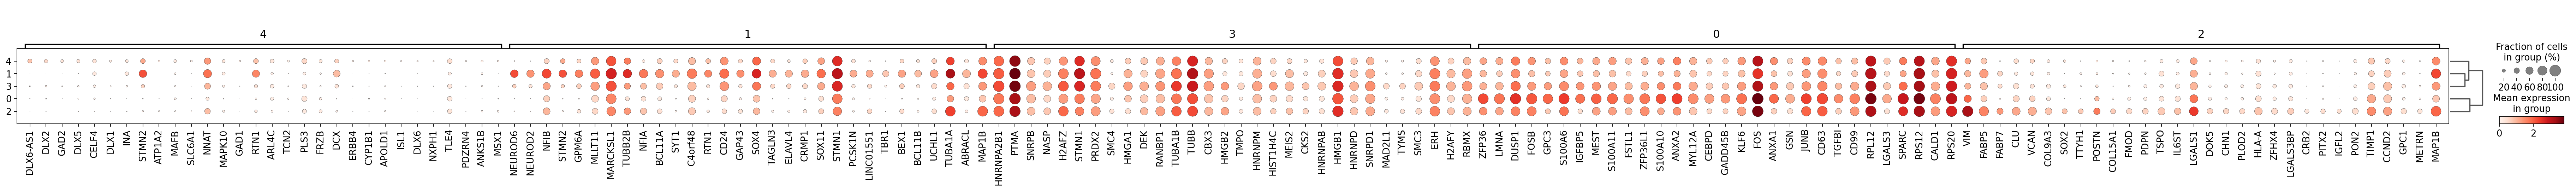

In [75]:
# Plot with gene expression normalized and log transformed values
sc.pl.rank_genes_groups_dotplot(adata,
                                groupby='louvain_scVI_n_latent_9_sample_n_layers_3',
                                #groups = ['1'],
                                n_genes=30, dendrogram=True)

In [76]:
# 1 - PV
# 0,2,3,4 - dS/SCT contaminants

In [77]:
def annot_PV(adata_obj, barcode_sample):
    curr_clus = adata.obs.loc[barcode_sample,'louvain_scVI_n_latent_9_sample_n_layers_3']
    
    if curr_clus in ['0','2','3','4']:
        return('mix')
    elif curr_clus == '1':
        return('PV')
    else:
        return('none')
    

In [78]:
# mark contaminants here
adata.obs['annot_PV'] = adata.obs['barcode_sample_copy'].apply(lambda x: annot_PV(adata,x))

... storing 'annot_PV' as categorical


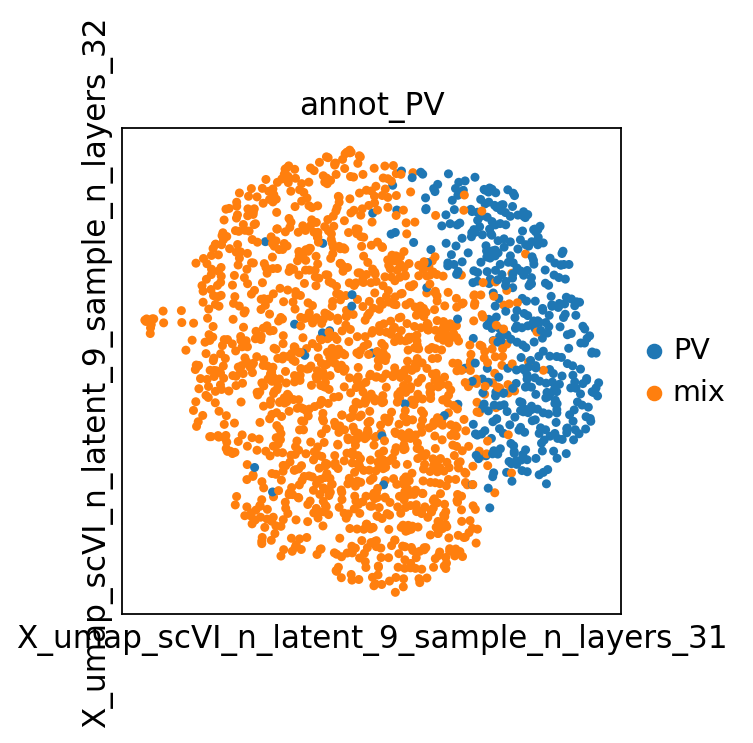

In [79]:
sc.pl.embedding(adata, curr_embedding_key, color=['annot_PV',
                                                 #'celltype_predictions','annotations_P13_troph','donor','technology'
                                                 ], #legend_loc='on data',
               ncols=1
               )

In [80]:
adata.obs.to_csv(save_path + 'annot_PV.csv')

In [56]:
# save coarse annotation to use for data subsetting
#adata.obs.to_csv(save_path + 'obs_table_with_coarse_annot_from_M4_notebook_all_cell_states.csv')